In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Disclaimer
* As mentioned, unfortunately the doc for Flava Zero Shot is broken page so I digged for a while 

# Notes 
* Flava has a ITM Image-Text Matching head used during pretraining (see paragraph "Image-Text Matching" in the Flava paper  https://arxiv.org/pdf/2112.04482.pdf) 
* But Zero-shot is done only with the contrastive matching loss (see "We perform zero-shot text retrieval and image retrieval (TR and IR) on Flickr30K and COCO based on their matching scores from the contrastive loss" in the paper)
* Consequently, on HuggingFace the documentation for FlavaModel is as follows (https://huggingface.co/docs/transformers/model_doc/flava#transformers.FlavaModel.forward.example) 

# HuggingFace FlavaModel demo (don't run, this does not work)

In [2]:
from PIL import Image
import requests
from transformers import AutoProcessor, FlavaModel

model = FlavaModel.from_pretrained("facebook/flava-full")
processor = AutoProcessor.from_pretrained("facebook/flava-full")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.contrastive_logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

`text_config_dict` is provided which will be used to initialize `FlavaTextConfig`. The value `text_config["id2label"]` will be overriden.
`multimodal_config_dict` is provided which will be used to initialize `FlavaMultimodalConfig`. The value `multimodal_config["id2label"]` will be overriden.
`image_codebook_config_dict` is provided which will be used to initialize `FlavaImageCodebookConfig`. The value `image_codebook_config["id2label"]` will be overriden.
Some weights of the model checkpoint at facebook/flava-full were not used when initializing FlavaModel: ['image_codebook.blocks.group_2.group.block_2.res_path.path.conv_2.bias', 'image_codebook.blocks.group_4.group.block_2.res_path.path.conv_3.bias', 'image_codebook.blocks.group_4.group.block_2.res_path.path.conv_4.weight', 'image_codebook.blocks.group_3.group.block_1.id_path.bias', 'mlm_head.transform.dense.bias', 'image_codebook.blocks.group_4.group.block_1.res_path.path.conv_3.weight', 'image_codebook.blocks.group_1.group.block_1.

AttributeError: 'FlavaModelOutput' object has no attribute 'contrastive_logits_per_image'

# But this doesn't work 
Unfortunately, running the HuggingFace Flaval model not only raises lots of warning but also raises an error
'FlavaModelOutput' object has no attribute 'contrastive_logits_per_image'

It was already opened in a github issue, left hanging...
https://github.com/huggingface/transformers/issues/18279

So I turned to the doc here to retrieve the logits (as someone also mentioned in the github issue you have to use 
FlavaForPreTraining if you want `contrastive_logits_per_image`) and followed the example for FlavaForPretraining on 
https://huggingface.co/facebook/flava-full

In [4]:
from PIL import Image
import requests
from transformers import FlavaProcessor, FlavaModel, FlavaForPreTraining

model = FlavaForPreTraining.from_pretrained("facebook/flava-full")
processor = FlavaProcessor.from_pretrained("facebook/flava-full")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(
  text=["a photo of a cat", "a photo of a dog"], 
  images=[image, image], 
  return_tensors="pt", 
  padding="max_length", 
  max_length=77,
  return_codebook_pixels=True,
  return_image_mask=True,
  # Other things such as mlm_labels, itm_labels can be passed here. See docs
)

inputs.bool_masked_pos.zero_()

`text_config_dict` is provided which will be used to initialize `FlavaTextConfig`. The value `text_config["id2label"]` will be overriden.
`multimodal_config_dict` is provided which will be used to initialize `FlavaMultimodalConfig`. The value `multimodal_config["id2label"]` will be overriden.
`image_codebook_config_dict` is provided which will be used to initialize `FlavaImageCodebookConfig`. The value `image_codebook_config["id2label"]` will be overriden.


tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# This is how the image looks btw 

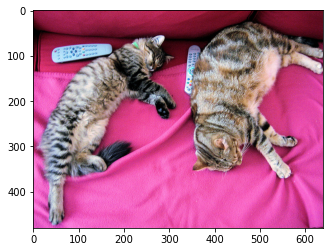

In [5]:
import matplotlib.pyplot as plt
plt.imshow(image)

In [6]:
model.eval() # This is Diane addition to make sure it's eval mode
outputs = model(**inputs)
# Global contrastive loss logits
image_contrastive_logits = outputs.contrastive_logits_per_image
print(image_contrastive_logits)

`input_ids_masked` isn't passed which means MLM loss won't be calculated correctlySetting it to `input_ids` so that model can work. Please pass it if this is unintentional. This is usually OKAY if you are doing inference on unmasked text...
/private/home/dianeb/.conda/envs/torch13/lib/python3.9/site-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


tensor([[16.1290,  8.4033],
        [16.1290,  8.4033]], grad_fn=<MulBackward0>)


# I do think the contrastive logits are what we want, since in the code it says clearly 
*contrastive_logits_per_image (`torch.FloatTensor` of shape `(image_batch_size, text_batch_size)`): The scaled dot product scores between `image_embeddings` and `text_embeddings` but passed through FLAVA's
 `image_projection` and `text_projection` layers respectively. This represents the image-text similarity scores*

see 
https://github.com/huggingface/transformers/blob/74c55ab9e538f9ebefed1e40198fca7894bc31a9/src/transformers/models/flava/modeling_flava.py#L200
    

In [7]:
probs_imgtotext = image_contrastive_logits.softmax(dim=1)  
print(probs_imgtotext.shape)
print(probs_imgtotext)

torch.Size([2, 2])
tensor([[9.9956e-01, 4.4112e-04],
        [9.9956e-01, 4.4112e-04]], grad_fn=<SoftmaxBackward0>)


# The BIG caveat 
is that we would need to pass the image 1000 times to compute its similarity with 1000 classes, so I think this is unfeasible. Plus, the FalavaForPreTraining head uses the temperature scaling (logits scale)
see https://github.com/huggingface/transformers/blob/74c55ab9e538f9ebefed1e40198fca7894bc31a9/src/transformers/models/flava/modeling_flava.py#L1686

# Proposed solution 
Get the image embeddings as in https://huggingface.co/facebook/flava-full#encode-image
I think the warning that comes up is OK, since we use the loaded model for a different purpose indeed
Note: I switched to FlavaImageProcessor since FlavaFeatureExtractor used in the doc was deprecated according to a warning

In [8]:
from PIL import Image
import requests

from transformers import FlavaImageProcessor, FlavaModel

model = FlavaModel.from_pretrained("facebook/flava-full")
feature_extractor = FlavaImageProcessor.from_pretrained("facebook/flava-full")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

inputs = feature_extractor(images=[image], return_tensors="pt")

image_embeddings = model.get_image_features(**inputs)


`text_config_dict` is provided which will be used to initialize `FlavaTextConfig`. The value `text_config["id2label"]` will be overriden.
`multimodal_config_dict` is provided which will be used to initialize `FlavaMultimodalConfig`. The value `multimodal_config["id2label"]` will be overriden.
`image_codebook_config_dict` is provided which will be used to initialize `FlavaImageCodebookConfig`. The value `image_codebook_config["id2label"]` will be overriden.
Some weights of the model checkpoint at facebook/flava-full were not used when initializing FlavaModel: ['image_codebook.blocks.group_2.group.block_2.res_path.path.conv_2.bias', 'image_codebook.blocks.group_4.group.block_2.res_path.path.conv_3.bias', 'image_codebook.blocks.group_4.group.block_2.res_path.path.conv_4.weight', 'image_codebook.blocks.group_3.group.block_1.id_path.bias', 'mlm_head.transform.dense.bias', 'image_codebook.blocks.group_4.group.block_1.res_path.path.conv_3.weight', 'image_codebook.blocks.group_1.group.block_1.

Get the text embeddings as in https://huggingface.co/facebook/flava-full#encode-text
where I added the second "class" dog

In [9]:
from PIL import Image

from transformers import BertTokenizer, FlavaModel

# We already have the model
# model = FlavaModel.from_pretrained("facebook/flava-full")
tokenizer = BertTokenizer.from_pretrained("facebook/flava-full")

inputs = tokenizer(text=["a photo of a cat", "a photo of a dog"], return_tensors="pt", padding="max_length", max_length=77)

text_embeddings = model.get_text_features(**inputs)

# Do the dot product ourselves as said there
https://github.com/huggingface/transformers/blob/main/src/transformers/models/flava/modeling_flava.py#L74
This gives less peaky scores and I can't understand why unfortunately :/ So far I have spent a lot of time in source code etc, but that's the best I came up with

I followed https://github.com/huggingface/transformers/blob/6e32959329822136051d2416481307ef81b27096/src/transformers/models/flava/modeling_flava.py#L2004

And I noted that the embeddings are already projected by looking at source code e.g. https://github.com/huggingface/transformers/blob/74c55ab9e538f9ebefed1e40198fca7894bc31a9/src/transformers/models/flava/modeling_flava.py#L1331

In [11]:
import torch 
text_embedding = text_embeddings[:,0,:]
text_embedding = torch.nn.functional.normalize(text_embedding, dim=-1)
image_embedding = image_embeddings[:,0,:]
image_embedding = torch.nn.functional.normalize(image_embedding, dim=-1)

logits = torch.matmul(image_embedding, text_embedding.transpose(1,0))
print(logits)
print(torch.softmax(logits,dim=-1))

tensor([[0.2627, 0.1369]], grad_fn=<MmBackward0>)
tensor([[0.5314, 0.4686]], grad_fn=<SoftmaxBackward0>)


Other solution, following the code we use exactly the image embeddings and text embeddings from the FlavaModel inside the flava pretraining as there 
https://github.com/huggingface/transformers/blob/74c55ab9e538f9ebefed1e40198fca7894bc31a9/src/transformers/models/flava/modeling_flava.py#L1870

This would require passing as many times the image as the text so probably not the best solution at all. But this gives the same scores ! 

In [12]:
from PIL import Image
import requests
from transformers import FlavaProcessor, FlavaModel

model = FlavaModel.from_pretrained("facebook/flava-full")
processor = FlavaProcessor.from_pretrained("facebook/flava-full")

`text_config_dict` is provided which will be used to initialize `FlavaTextConfig`. The value `text_config["id2label"]` will be overriden.
`multimodal_config_dict` is provided which will be used to initialize `FlavaMultimodalConfig`. The value `multimodal_config["id2label"]` will be overriden.
`image_codebook_config_dict` is provided which will be used to initialize `FlavaImageCodebookConfig`. The value `image_codebook_config["id2label"]` will be overriden.
Some weights of the model checkpoint at facebook/flava-full were not used when initializing FlavaModel: ['image_codebook.blocks.group_2.group.block_2.res_path.path.conv_2.bias', 'image_codebook.blocks.group_4.group.block_2.res_path.path.conv_3.bias', 'image_codebook.blocks.group_4.group.block_2.res_path.path.conv_4.weight', 'image_codebook.blocks.group_3.group.block_1.id_path.bias', 'mlm_head.transform.dense.bias', 'image_codebook.blocks.group_4.group.block_1.res_path.path.conv_3.weight', 'image_codebook.blocks.group_1.group.block_1.

In [14]:
print(model.training)
inputs = processor(text=["a photo of a cat"], images=image, return_tensors="pt", padding="max_length", 
  max_length=77)

outputs = model(**inputs)
image_embeddings = outputs.image_embeddings
text_embeddings = outputs.text_embeddings

text_embedding = model.text_projection(text_embeddings[:, 0, :])
text_embedding = torch.nn.functional.normalize(text_embedding, dim=-1)
image_embedding = model.image_projection(image_embeddings[:, 0, :])
image_embedding = torch.nn.functional.normalize(image_embedding, dim=-1)

logit_for_class1 = torch.matmul(image_embedding, text_embedding.transpose(1,0))
print(logit_for_class1)

False
tensor([[0.2627]], grad_fn=<MmBackward0>)


In [15]:
inputs = processor(text=["a photo of a dog"], images=image, return_tensors="pt", padding="max_length", 
  max_length=77)

outputs = model(**inputs)
image_embeddings = outputs.image_embeddings
text_embeddings = outputs.text_embeddings

text_embedding = model.text_projection(text_embeddings[:, 0, :])
text_embedding = torch.nn.functional.normalize(text_embedding, dim=-1)

logit_for_class2 = torch.matmul(image_embedding, text_embedding.transpose(1,0))
print(logit_for_class2)

logits = torch.FloatTensor([logit_for_class1,logit_for_class2])
print(torch.softmax(logits,dim=-1))

tensor([[0.1369]], grad_fn=<MmBackward0>)
tensor([0.5314, 0.4686])
